## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [28]:

from keras.layers import Dropout

def build_mlp(input_shape, output_neurons=10, num_neurons=[512, 256, 128], l1_ratio_p = 1e-5 , l2_ratio_p = 1e-4 , l1_l2_sel = False , drp_ratio=0.2):
    inputs = keras.layers.Input(input_shape)
    
    for i, neuron in enumerate(num_neurons):
        if i == 0:
          if l1_l2_sel == True:
            x = keras.layers.Dense(units = neuron , activation = 'relu' , kernel_regularizer = keras.regularizers.l1_l2(l1 = l1_ratio_p , l2 = l2_ratio_p))(inputs)
          else:
            x = keras.layers.Dense(units = neuron , activation = 'relu' , kernel_regularizer = keras.regularizers.l1(l1_ratio_p) )(inputs)
          x = Dropout(drp_ratio)(x)
          x = keras.layers.BatchNormalization()(x)
        else:
          if l1_l2_sel == False:
            x = keras.layers.Dense(units = neuron , activation = 'relu' , kernel_regularizer = keras.regularizers.l1(l1_ratio_p))(x)
          else:
            x = keras.layers.Dense(units = neuron , activation = 'relu' , kernel_regularizer = keras.regularizers.l1_l2(l1 = l1_ratio_p , l2 = l2_ratio_p))(x)
          x = Dropout(drp_ratio)(x)
          x = keras.layers.BatchNormalization()(x)
    
    if l1_l2_sel == False:
      outputs = keras.layers.Dense(units = output_neurons , activation = 'softmax' , kernel_regularizer = keras.regularizers.l1(l1_ratio_p))(x)
    else:
      outputs = keras.layers.Dense(units = output_neurons , activation = 'softmax' , kernel_regularizer = keras.regularizers.l1_l2(l1 = l1_ratio_p , l2 = l2_ratio_p))(x)
    
    model = keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [29]:
"""Code Here
設定超參數
"""
epochs = 20
batch_size = 128
l1_ratio = [1e-2 , 1e-3 , 1e-4]
l2_ratio = [1e-2 , 1e-3 , 1e-4]

In [30]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i in range(2):
  for l1_z , l2_z in zip(l1_ratio , l2_ratio):
    keras.backend.clear_session()
    
    if i ==0:
      model = build_mlp(x_train.shape[1:] , l1_ratio_p = l1_z , l2_ratio_p = l2_z , l1_l2_sel = True)
    else:
      model = build_mlp(x_train.shape[1:] , l1_ratio_p = l1_z , l2_ratio_p = l2_z , l1_l2_sel = False)

    model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['acc'])
    model.fit(x_train , y_train , epochs = epochs , batch_size = batch_size , validation_data = (x_test , y_test) , shuffle = True)

    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
      
    results[i] = {'train-loss': train_loss,
                  'valid-loss': valid_loss,
                  'train-acc': train_acc,
                  'valid-acc': valid_acc}

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 8s 166us/step - loss: 34.3445 - acc: 0.2055 - val_loss: 5.6498 - val_acc: 0.1433
Epoch 2/20
50000/50000 [==============================] - 6s 117us/step - loss: 5.4227 - acc: 0.1965 - val_loss: 5.3232 - val_acc: 0.1699
Epoch 3/20
50000/50000 [==============================] - 6s 118us/step - loss: 5.3777 - acc: 0.1923 - val_loss: 5.8172 - val_acc: 0.1344
Epoch 4/20
50000/50000 [==============================] - 6s 118us/step - loss: 5.3047 - acc: 0.1939 - val_loss: 5.4343 - val_acc: 0.2083
Epoch 5/20
50000/50000 [==============================] - 6s 120us/step - loss: 5.2027 - acc: 0.1892 - val_loss: 5.4447 - val_acc: 0.1781
Epoch 6/20
50000/50000 [==============================] - 6s 118us/step - loss: 5.1544 - acc: 0.1896 - val_loss: 6.2681 - val_acc: 0.1035
Epoch 7/20
50000/50000 [==============================] - 6s 118us/step - loss: 4.9800 - acc: 0.1883 - val_loss: 4.7867 -

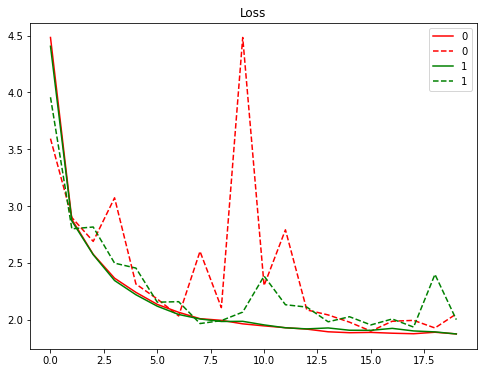

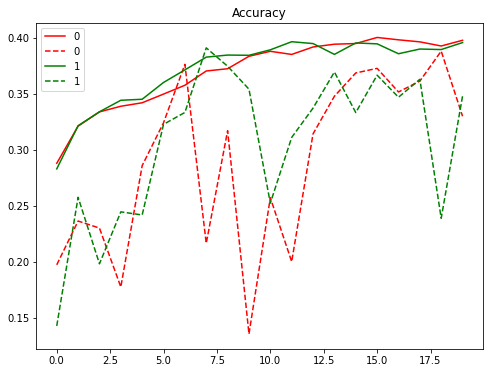

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]
plt.figure(figsize=(8,6))

for i , cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()